In [1]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [2]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [3]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [4]:
import numpy as np
import pandas as pd
import torch
from core.models import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from core.data_preparation import DataPreparation


In [5]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [7]:
filepath = "../Data/RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1075.50
1,2010-01-05,1070.70
2,2010-01-06,1088.00
3,2010-01-07,1106.05
4,2010-01-08,1103.15


In [8]:
data.tail()

,date,close
2890,2021-08-23,2162.35
2891,2021-08-24,2183.70
2892,2021-08-25,2202.60
2893,2021-08-26,2230.45
2894,2021-08-27,2227.40


In [9]:
len(data)

2895

In [148]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [149]:
TsAD = importr('otsad')
TSdist = importr('TSdist')

In [150]:
train_len = 0.8*len(data)

In [151]:
res = TsAD.OcpTsSdEwma(data['close'].values, train_len, 0.01, 3, 50 )

In [152]:
df = pd.DataFrame(res)

In [153]:
df.head()

,is.anomaly,lcl,ucl
0,0.0,1075.50,1075.50
1,0.0,1070.70,1070.70
2,0.0,1088.00,1088.00
3,0.0,1106.05,1106.05
4,0.0,1103.15,1103.15


In [154]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index, y=df['lcl'], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index, y=df['ucl'], mode='lines', name='upper control limit'))
# fig.add_trace(go.Scatter(x=df.index[2316:2416], y=preds, mode='lines', name='predictions'))


# fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [155]:
anomaly_indices = df[df['is.anomaly'] == 1.0].index

In [156]:
rows = data.iloc[anomaly_indices, :]

In [157]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='lines'))
fig.add_trace(go.Scatter(x=rows['date'], y=rows['close'], mode='markers', name='markers'))

fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [158]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [159]:
train_set, test_set = prep.splitData(data['close'].values)

In [160]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [161]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [162]:
torch.save(model, 'lstm_rel.pt')

In [163]:
actual_test_len = len(test_set) - window_size

In [164]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

In [165]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['lcl'][-actual_test_len:], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['ucl'][-actual_test_len:], mode='lines', name='upper control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


fig.update_yaxes(range=[500, 2500])

#### Find distance between forecast distributions and actual test values using different distance measures from R

### Dynamic Time Warping

In [166]:
dtw_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [167]:
pdc_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  pdc = TSdist.PDCDistance(X1, X2)
  pdc_dist.append(pdc.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [168]:
cort_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [169]:
df3

,range,Temporal Correlation distance
0,0 : 100,1206.474742
1,100 : 200,1548.998812
2,200 : 300,5843.643337
3,300 : 400,19691.194460
4,400 : 500,9649.533260


In [170]:
fourier_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

In [171]:
df4

,range,Fourier distance
0,0 : 100,1973.719909
1,100 : 200,2690.382650
2,200 : 300,8672.441008
3,300 : 400,17935.132624
4,400 : 500,14868.235171


#### KL divergence

In [172]:
def computeKLD(X1, X2, bins=5):

    # values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    # values_2, edges_2 = np.histogram(X2,bins=bins,density=True)

    values_1, edges_1 = np.histogram(X1,bins=bins)
    values_2, edges_2 = np.histogram(X2,bins=bins)
   
    #Consider only first std. deviation of original series i.e. P(x).    
    P = values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log2( P/Q )) * delta_x
    return res

In [173]:
KLD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    kld_res = computeKLD(X1, X2)

    KLD.append(kld_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "KL divergence" : KLD

}

df5 = pd.DataFrame(finalResult)

#### Jensen Shannon Divergence

In [174]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [175]:
JSD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [176]:
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'],
 df4['Fourier distance'], df5['KL divergence'], df6['JS divergence']], axis=1)
result

,range,DTW distance,PDC distance,Temporal Correlation distance,Fourier distance,KL divergence,JS divergence
0,0 : 100,1186.820190,0.608063,1206.474742,1973.719909,0.488970,0.000061
1,100 : 200,1710.466553,0.435555,1548.998812,2690.382650,0.710354,0.000084
2,200 : 300,5599.477478,0.722580,5843.643337,8672.441008,1.086900,0.000249
3,300 : 400,18224.485107,0.828754,19691.194460,17935.132624,1.896460,0.000115
4,400 : 500,9993.230835,0.765536,9649.533260,14868.235171,2.025766,0.000085


In [177]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-len(x_test):], y=data['close'][-len(x_test):], mode='lines', name='closing price'))

# fig.update_xaxes(range=["2018-07-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [178]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[:100], y=y_test[:100,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[:100], y= y_test_pred[:100,0], mode='lines', name='predicted close price'))


fig.update_yaxes(range=[1000, 1500])

In [179]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[100:200], y=y_test[100:200,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[100:200], y= y_test_pred[100:200,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[1000, 1500])

In [180]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[200:300], y=y_test[200:300,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[200:300], y= y_test_pred[200:300,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[1000, 1500])

In [181]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[300:400], y=y_test[300:400,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[300:400], y= y_test_pred[300:400,0], mode='lines', name='predicted close price'))

In [182]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[400:500], y=y_test[400:500,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[400:500], y= y_test_pred[400:500,0], mode='lines', name='predicted close price'))

#### Measure how accuracy of model changes with shift in test set

In [183]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) *100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [184]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,27.891849,1.669585,0.810739
1,100 : 200,37.081407,1.970305,0.919765
2,200 : 300,103.022918,4.612120,0.906988
3,300 : 400,185.581729,8.164647,-1.370957
4,400 : 500,153.534866,7.069485,-2.091900


In [185]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(8):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [186]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,29.628981,1.749787,0.685558
1,70 : 140,26.856682,1.518385,0.952918
2,140 : 210,47.133102,2.755424,0.944063
3,210 : 280,63.627978,3.246229,0.902331
4,280 : 350,216.608482,9.647360,-4.736759
5,350 : 420,132.016970,6.219834,-5.616920
6,420 : 490,151.742612,7.126106,-2.444127
7,490 : 560,200.172309,9.120893,-7.141950


In [187]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(11):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [188]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,21.862274,1.466220,0.844715
1,50 : 100,32.832170,1.872950,0.785726
2,100 : 150,29.439392,1.586831,0.658086
3,150 : 200,43.397971,2.353779,0.921883
4,200 : 250,55.269042,3.517238,0.917531
5,250 : 300,134.806437,5.707004,0.557694
6,300 : 350,226.208776,9.980036,-7.274816
7,350 : 400,133.081727,6.349260,-8.686429
8,400 : 450,159.150768,7.250109,-1.768542
9,450 : 500,147.705610,6.888860,-2.896009


#### ECDF distance measures between actual values and forecasts

In [189]:
wasserstein_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Wasserstein_Dist(X1, X2)

    wasserstein_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Wasserstein distance" : wasserstein_distance

}

df7 = pd.DataFrame(finalResult)

In [190]:
KS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Kolmogorov_Smirnov_Dist(X1, X2)

    KS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Kolmogorov Smirnov distance" : KS_distance

}

df8 = pd.DataFrame(finalResult)

In [191]:
DTS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = DTS_Dist(X1, X2)

    DTS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "DTS distance" : DTS_distance

}

df9 = pd.DataFrame(finalResult)

In [192]:
result = pd.concat([df7, df8['Kolmogorov Smirnov distance'], df9['DTS distance']], axis=1)
result

,range,Wasserstein distance,Kolmogorov Smirnov distance,DTS distance
0,0 : 100,4.684822,0.06,1.227363
1,100 : 200,19.443554,0.17,5.071264
2,200 : 300,68.603438,0.18,15.603981
3,300 : 400,172.847822,0.65,31.164015
4,400 : 500,143.573906,0.74,25.835892


#### ECDF distance measures between train set and test set

In [193]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [194]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [195]:
test_set_range = []
finalResult2 = []

for i in range(8):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [196]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score']], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,27.891849,0.810739,44.943650,919.306356,17.202077,0.875579,0.895440,308.084918
1,37.081407,0.919765,53.360855,1005.792038,32.800319,0.860846,0.865596,489.908211
2,103.022918,0.906988,53.258034,974.076805,60.514697,0.781192,0.781192,621.147484
3,185.581729,-1.370957,60.854420,1085.242038,99.163742,1.000000,1.000000,1108.606004
4,153.534866,-2.091900,60.850445,1085.172038,89.886198,1.000000,1.000000,1034.509996


In [197]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,44.283804,900.000074,16.941659,0.871293,0.909289,298.587729
1,70 : 140,52.794799,991.246422,32.132409,0.896373,0.901123,459.474070
2,140 : 210,46.568699,876.615075,27.443920,0.686763,0.695830,392.110418
3,210 : 280,56.131990,1014.171293,51.617367,0.876906,0.876906,563.165340
4,280 : 350,61.803354,1071.067752,119.428512,1.000000,1.000000,1182.599637
5,350 : 420,61.714581,1070.524895,94.386384,1.000000,1.000000,996.976089
6,420 : 490,61.803354,1071.067752,102.466280,1.000000,1.000000,1042.103199
7,490 : 560,61.699195,1069.726966,115.060449,1.000000,1.000000,1155.867567


In [198]:
frames = [acc_df2[['RMSE',  'R2-score']], df1]
df_new = pd.concat(frames, axis=1)
df_new


,RMSE,R2-score,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,29.628981,0.685558,0 : 70,44.283804,900.000074,16.941659,0.871293,0.909289,298.587729
1,26.856682,0.952918,70 : 140,52.794799,991.246422,32.132409,0.896373,0.901123,459.474070
2,47.133102,0.944063,140 : 210,46.568699,876.615075,27.443920,0.686763,0.695830,392.110418
3,63.627978,0.902331,210 : 280,56.131990,1014.171293,51.617367,0.876906,0.876906,563.165340
4,216.608482,-4.736759,280 : 350,61.803354,1071.067752,119.428512,1.000000,1.000000,1182.599637
5,132.016970,-5.616920,350 : 420,61.714581,1070.524895,94.386384,1.000000,1.000000,996.976089
6,151.742612,-2.444127,420 : 490,61.803354,1071.067752,102.466280,1.000000,1.000000,1042.103199
7,200.172309,-7.141950,490 : 560,61.699195,1069.726966,115.060449,1.000000,1.000000,1155.867567


In [199]:
test_set_range = []
finalResult3 = []

for i in range(11):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [200]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,44.599001,896.710674,17.721299,0.870898,0.908895,305.233034
1,50 : 100,45.295833,903.125579,18.685398,0.892919,0.912781,315.430004
2,100 : 150,57.083393,1027.650915,41.374411,0.978843,0.983592,551.675208
3,150 : 200,50.479374,938.598826,30.527129,0.789620,0.798687,428.530418
4,200 : 250,44.727345,845.719689,24.344893,0.703109,0.712176,347.964178
5,250 : 300,62.150204,1057.568204,101.855598,0.986183,0.986183,894.880486
6,300 : 350,62.617000,1061.062038,138.547876,1.000000,1.000000,1211.124490
7,350 : 400,62.501299,1060.402038,105.951313,1.000000,1.000000,1005.486516
8,400 : 450,62.617000,1061.062038,116.984621,1.000000,1.000000,1050.169505
9,450 : 500,62.617000,1061.062038,112.451097,1.000000,1.000000,1018.613484


In [201]:
y_values = 100 - acc_df2['MAPE']*100
y_values

0    -74.978655
1    -51.838511
2   -175.542382
3   -224.622877
4   -864.735970
5   -521.983446
6   -612.610558
7   -812.089348
Name: MAPE, dtype: float64

In [202]:
fig = px.scatter(x=df_new['Wasserstein_dist'], y=y_values, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (1-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [203]:
# plt.plot(df_new['Wasserstein_dist'], y_values, 'ro-')
# plt.show()

In [204]:
y_values3 = 100 - acc_df3['MAPE']*100
# y_values3

In [205]:
fig = px.scatter(x=df3['Wasserstein_dist'], y=y_values3, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (1-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [206]:
fig = px.scatter(x=df3['Wasserstein_dist'], y=acc_df3['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [207]:
x = np.array(df3['Wasserstein_dist'].values)
y = np.array(acc_df3['RMSE'].values)
z = np.polyfit(x, y, 2)
z

array([ 2.30358385e-04, -1.43963786e-01,  5.72047069e+01])

In [208]:
p = np.poly1d(z)

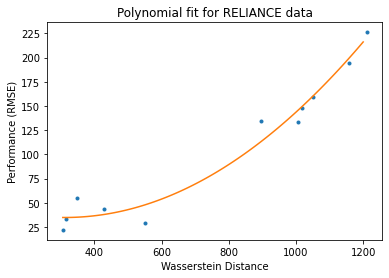

In [209]:
import matplotlib.pyplot as plt
xp = np.linspace(306, 1200, 100)
_ = plt.plot(x, y, '.', xp, p(xp))
plt.xlabel('Wasserstein Distance')
plt.ylabel('Performance (RMSE)')
plt.title('Polynomial fit for RELIANCE data')
plt.show()

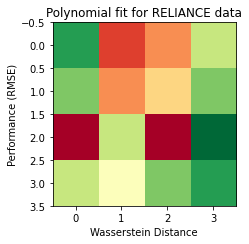

In [6]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
data = np.array(
   [[0.1, 0.7, 0.6, 0.3],
   [0.2, 0.6, 0.5, 0.2],
   [0.8, 0.3, 0.80, 0.01],
   [0.3, 0.4, 0.2, 0.1]]
)
plt.imshow(data, interpolation="nearest", cmap="RdYlGn_r")
plt.xlabel('Wasserstein Distance')
plt.ylabel('Performance (RMSE)')
plt.title('Polynomial fit for RELIANCE data')
plt.savefig("myimage.eps", dpi=1200)
plt.show()

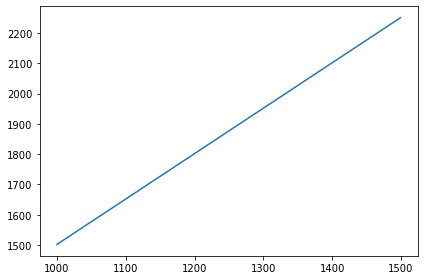

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [10, 5]
x = np.arange(1000, 1500)
m = 1.5
c = 2
y = m*x + c

fig, ax = plt.subplots(1, 1 , figsize=(6,4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(x, y )

# plt.plot(x, y)
# plt.title("y=mx+c")
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')
# plot_margin = 1

# x0, x1, y0, y1 = plt.axis()
# plt.axis((x0 - plot_margin,
#           x1 + plot_margin,
#           y0 - plot_margin,
#           y1 + plot_margin))
plt.savefig("High resoltion.png",dpi=1200)

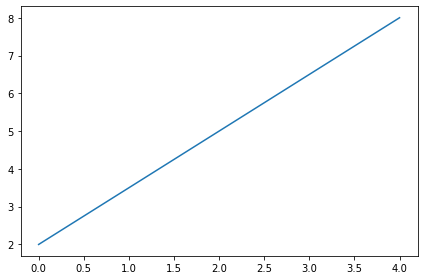

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [10, 5]
x = np.arange(0, 5)
m = 1.5
c = 2
y = m*x + c

fig, ax = plt.subplots(1, 1 , figsize=(6,4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(x, y )
# plt.subplot(x, y)
# plt.title("y=mx+c")
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

plt.savefig("High resoltion1.png",dpi=1200)

In [210]:
res = pd.DataFrame({'dist': x,
            'rmse': y})

In [211]:
res.sort_values(by=['dist'])

,dist,rmse
0,305.233034,21.862274
1,315.430004,32.832170
4,347.964178,55.269042
3,428.530418,43.397971
2,551.675208,29.439392
5,894.880486,134.806437
7,1005.486516,133.081727
9,1018.613484,147.705610
8,1050.169505,159.150768
10,1156.919495,193.947611


In [212]:
df3 = pd.concat([df3[['Test set range']], acc_df3.iloc[:, 1:], df3.iloc[:, 1:]], axis=1)

In [213]:
df3.to_csv('Reliance_results.csv', index=False)

In [214]:
fig = px.scatter(x=res['dist'], y=res['rmse'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [215]:
from scipy.interpolate import interp1d

In [216]:
xp = np.linspace(306, 1200, 50)

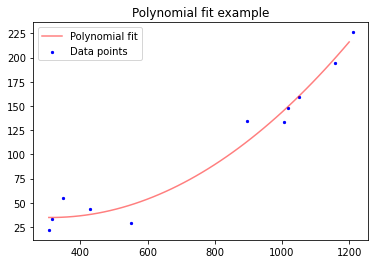

In [217]:
#-----POLYNOMIAL FIT----
# x = np.array(df_new['Wasserstein_dist'].values)
# y = np.array(acc_df2['RMSE'].values)

x=res['dist'].values
y=res['rmse'].values
fit = np.polyfit(x, y, 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(x) + b * x + c
xp = np.linspace(306, 1200, 50)
fit_equation_p = a * np.square(xp) + b * xp + c
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(xp, fit_equation_p,color = 'r',alpha = 0.5, label = 'Polynomial fit')
ax1.scatter(x, y, s = 5, color = 'b', label = 'Data points')
ax1.set_title('Polynomial fit example')
ax1.legend()
plt.show()

In [218]:
index = [2, 4, 7, 9]
x1 = np.array(np.delete(x, index))

In [219]:
index = [2, 4, 7, 9]
y1 = np.array(np.delete(y, index))

In [220]:
x1 = np.sort(x1)
x1

array([ 305.23303388,  315.43000397,  428.53041817,  894.88048622,
       1050.16950478, 1156.91949501, 1211.12449013])

In [221]:
y1 = np.sort(y1)
y1

array([ 21.86227378,  32.83217044,  43.39797128, 134.80643676,
       159.1507675 , 193.94761092, 226.2087756 ])

In [222]:
pd.DataFrame({'dist': x1,
            'rmse': y1})

,dist,rmse
0,305.233034,21.862274
1,315.430004,32.832170
2,428.530418,43.397971
3,894.880486,134.806437
4,1050.169505,159.150768
5,1156.919495,193.947611
6,1211.124490,226.208776


In [223]:
fig = px.scatter(x=x1, y=y1, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [224]:
x1 = np.append(x1, [310.2, 313.4, 550.6, 664.8, 775.9, 1000.33 ])

In [225]:
x1 = np.sort(x1)
x1

array([ 305.23303388,  310.2       ,  313.4       ,  315.43000397,
        428.53041817,  550.6       ,  664.8       ,  775.9       ,
        894.88048622, 1000.33      , 1050.16950478, 1156.91949501,
       1211.12449013])

In [226]:
y1 = np.append(y1, [30.2, 31.4, 55.6, 66.8, 75.9, 140.33 ])

In [227]:
y1 = np.sort(y1)
y1

array([ 21.86227378,  30.2       ,  31.4       ,  32.83217044,
        43.39797128,  55.6       ,  66.8       ,  75.9       ,
       134.80643676, 140.33      , 159.1507675 , 193.94761092,
       226.2087756 ])

In [228]:
pd.DataFrame({'dist': x1,
            'rmse': y1})

,dist,rmse
0,305.233034,21.862274
1,310.200000,30.200000
2,313.400000,31.400000
3,315.430004,32.832170
4,428.530418,43.397971
5,550.600000,55.600000
6,664.800000,66.800000
7,775.900000,75.900000
8,894.880486,134.806437
9,1000.330000,140.330000


In [229]:
fig = px.scatter(x=x1, y=y1, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

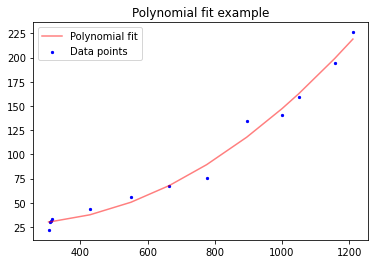

In [230]:
#-----POLYNOMIAL FIT----
# x = np.array(df_new['Wasserstein_dist'].values)
# y = np.array(acc_df2['RMSE'].values)

x=x1
y=y1
fit = np.polyfit(x, y, 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(x) + b * x + c
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(x, fit_equation,color = 'r',alpha = 0.5, label = 'Polynomial fit')
ax1.scatter(x, y, s = 5, color = 'b', label = 'Data points')
ax1.set_title('Polynomial fit example')
ax1.legend()
plt.show()

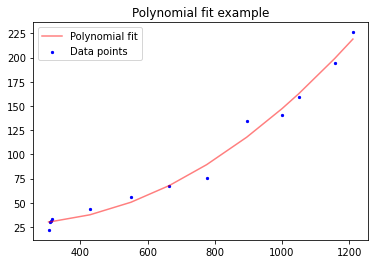

In [231]:
#-----POLYNOMIAL FIT----
# x = np.array(df_new['Wasserstein_dist'].values)
# y = np.array(acc_df2['RMSE'].values)

x=x1
y=y1
fit = np.polyfit(x, y, 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(x) + b * x + c
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(x, fit_equation,color = 'r',alpha = 0.5, label = 'Polynomial fit')
ax1.scatter(x, y, s = 5, color = 'b', label = 'Data points')
ax1.set_title('Polynomial fit example')
ax1.legend()
plt.show()

In [232]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [233]:
y_values = 100 - acc_df2['MAPE']*100
y_values

0    -74.978655
1    -51.838511
2   -175.542382
3   -224.622877
4   -864.735970
5   -521.983446
6   -612.610558
7   -812.089348
Name: MAPE, dtype: float64

In [234]:
df_new['Wasserstein_dist'].values

array([ 298.58772917,  459.47406973,  392.11041834,  563.16534009,
       1182.59963661,  996.97608925, 1042.10319932, 1155.86756715])

In [235]:
xs = df['Wasserstein_dist'].values
ys = y_values.tolist()

In [236]:
fig = px.scatter(x=df['Wasserstein_dist'], y=df['R2-score'])
fig.update_traces(marker_size=10)
fig.show()

#### Timseries based similarity measures between train and test

In [237]:
def get_timeseries_distance_measures(X1, X2):
    
    DTW_distance = TSdist.DTWDistance(X1, X2)    
    Jensen_Shannon_distance = jsd(X1, X2)
    KL_Divergence = computeKLD(X1, X2, 7)

    return {'DTW_distance': "{:.2f}".format(DTW_distance.item()),            
            'Jensen_Shannon_distance':Jensen_Shannon_distance,
            'KL_Divergence': KL_Divergence
        }

In [238]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]
    distances = get_timeseries_distance_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [239]:
df2 = pd.DataFrame(finalResult)
df2.insert(0, 'Test set range', test_set_range)
df2

,Test set range,DTW_distance,Jensen_Shannon_distance,KL_Divergence
0,0 : 100,431137.25,0.004265,3695.134510
1,100 : 200,312952.90,0.004203,5150.054992
2,200 : 300,202731.25,0.009630,3605.693834
3,300 : 400,2117103.71,0.003464,3342.584253
4,400 : 500,2078125.62,0.004787,3319.723910


In [ ]:
result = pd.DataFrame(finalResult)
result.insert(0, 'Noise Variance', variance)
result.insert(0, 'Noise Mean', means)
result

,Noise Mean,Noise Variance,DTW_distance,Jensen_Shannon_distance,KL_Divergence
0,2.5,1.0,432159.29,0.009816,1940.511123
1,5.0,30.0,428763.79,0.009106,1945.142361
2,10.0,40.0,407368.14,0.010103,1992.984224
3,50.0,5.0,493563.78,0.008914,1930.151943
4,100.0,12.5,553842.19,0.008737,1950.476192


#### JS divergence requires 2 data vectors of equal length, but resampling would affect the autocorrelation existing in timeseries. ECDF measures overcome this problem, timeseries distance measures that work for unequal length is only DTW. Therefore, we have to study other statistical properties of timeseries in addition to DTW.